# CIFAR-10: Convolutional Neural Networks


This dataset contains 60,000 images. It has 10 different classes. THe images are 32x32X3. They are colored images. Because they are colored images we are going to use GPU. 
GPU allows data processing to be done in parallel which speeds up training time.

In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt
%matplotlib inline

from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU...')
else:
    print('CUDA is available! Training on GPU...')

CUDA is available! Training on GPU...


In [3]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))])

In [4]:
train_data = datasets.CIFAR10('data', train=True, download=True,
                             transform=transform)

test_data = datasets.CIFAR10('data', train=False, download=True, 
                            transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# number of processors to use for data loading
num_workers = 0

batch_size = 20

valid_size = 0.2


num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# preparing the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          sampler=train_sampler, num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         num_workers=num_workers)

In [6]:
# specifying the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog',
          'frog', 'horse', 'ship', 'truck']

In [7]:
images, labels = next(iter(train_loader))

In [8]:
def show_image(images, num_of_images):
    
    fig = plt.figure(figsize=(25,4))
    
    for index in range(num_of_images):
        img = images[index] / 2 + 0.5
        img = np.transpose(img, (1,2,0))
        
        ax = fig.add_subplot(2, num_of_images/2, index+1, xticks=[], yticks=[])
        plt.imshow(img)
        ax.set_title(classes[labels[index]])

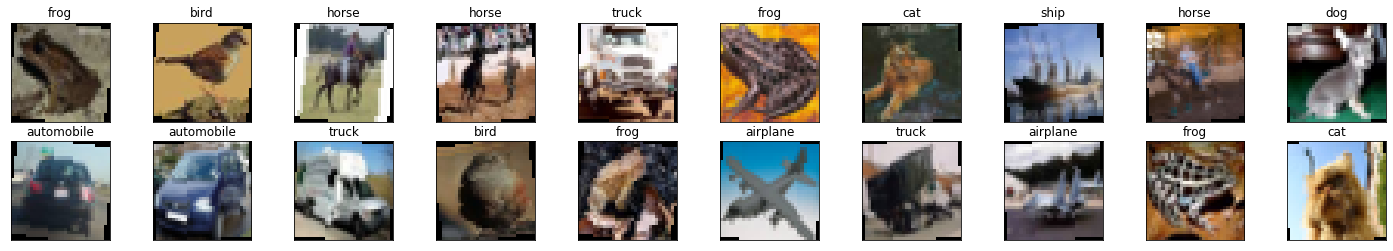

In [9]:
show_image(images, num_of_images=20)

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x
    
model = Net()

In [16]:
# moving the tensors to GPU
if train_on_gpu:
    model.cuda()

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [18]:

epochs = 10

valid_loss_min = np.inf

for epoch in range(epochs):
    train_loss = 0
    valid_loss = 0
    
    model.train()
    for images, labels in train_loader:
        
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
            
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    # validating the model
    model.eval()
    for images, labels in valid_loader:
        
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        output = model(images)
        loss = criterion(output, labels)
        valid_loss += loss.item()
        
    # calculating the losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    
    print(f'Epoch: {epoch+1} \nTraining loss: {train_loss} \nValidation loss: {valid_loss}')
    
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print(f'Validation decreased from {valid_loss_min} to {valid_loss}.')
        print('Saving the model ...')
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss
        

Epoch: 1 
Training loss: 0.1028143971145153 
Validation loss: 0.08983964604139329
Validation decreased from inf to 0.08983964604139329.
Saving the model ...
Epoch: 2 
Training loss: 0.08318973655998707 
Validation loss: 0.07670559970736504
Validation decreased from 0.08983964604139329 to 0.07670559970736504.
Saving the model ...
Epoch: 3 
Training loss: 0.07492045886665583 
Validation loss: 0.07058862512111663
Validation decreased from 0.07670559970736504 to 0.07058862512111663.
Saving the model ...
Epoch: 4 
Training loss: 0.06998167397677899 
Validation loss: 0.06496126616597175
Validation decreased from 0.07058862512111663 to 0.06496126616597175.
Saving the model ...
Epoch: 5 
Training loss: 0.06589053085297346 
Validation loss: 0.06161866816878319
Validation decreased from 0.06496126616597175 to 0.06161866816878319.
Saving the model ...
Epoch: 6 
Training loss: 0.06252436478286981 
Validation loss: 0.061726211872696876
Epoch: 7 
Training loss: 0.0594726446762681 
Validation loss: 0

In [19]:
# loading the model with the lowest validation loss

model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [20]:
# Testing the network

test_loss = 0
accuracy = 0

model.eval()

for images, labels in test_loader:
    images, labels = images.cuda(), labels.cuda()
    
    output = model(images)
    loss = criterion(output, labels)
    test_loss += loss.item()
    
    # converting the outputed probabilities to predicted class
    # _ : gives the indices of the determined max outputs
    # pred: returns with the max outputs in each row
    _, pred = torch.max(output, 1)
    
    
    # comparing prediction to actual label
    equality = pred == labels
    equality = equality.type(torch.FloatTensor)
    
    # calculating the accuracy
    accuracy += torch.mean(equality).item()
    
print(accuracy/len(test_loader))

0.6432999990582466


In [ ]:
test_img, test_label = next(iter(test_loader))

In [ ]:
test_img, test_label = test_img.cuda(), test_label.cuda()

In [ ]:
output = model(test_img)

In [ ]:
output[0]

In [ ]:
loss = criterion(output, test_label)

In [ ]:
test_loss = 0

In [ ]:
test_loss += loss.item()

In [ ]:
_, pred = torch.max(output, 1)

In [ ]:
_

In [ ]:
pred

In [ ]:
test_label

In [ ]:
pred.shape

In [ ]:
test_label.view(*pred.shape)

In [ ]:
equality = pred == test_label

In [ ]:
equality

In [ ]:
equality.type(torch.FloatTensor)

In [ ]:
torch.mean(equality.type(torch.FloatTensor))

In [ ]:
torch.mean(equality.type(torch.FloatTensor)).item()

In [ ]:
accuracy = torch.mean(equality.type(torch.FloatTensor)).item()/len(test_loader)

In [ ]:
accuracy

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))